In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import numpy as np
import h5py
from collections import OrderedDict
import modisco
import plot.viz_sequence as viz_sequence
import matplotlib.pyplot as plt
import tqdm
tqdm.tqdm_notebook(range(0))

TF-MoDISco is using the TensorFlow backend.
/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

|<bar/>| 0/0 [00:00<?, ?it/s]

In [2]:
condition_name = "K562"
model_type = "binary"
missed_seqlets_path = "/users/amtseng/att_priors/results/missed_seqlets/%s_%s_missed_seqlets.h5" % (condition_name, model_type)

In [3]:
# Import the data
with h5py.File(missed_seqlets_path, "r") as f:
    input_seqs = f["input_seqs"][:]
    prior_hyp_scores = f["prior_hyp_scores"][:]
    noprior_hyp_scores = f["noprior_hyp_scores"][:]
    prior_ranked_bases = f["prior_ranked_bases"][:]
    noprior_ranked_bases = f["noprior_ranked_bases"][:]
    prior_missed_inds = f["prior_missed_inds"][:]
    noprior_missed_inds = f["noprior_missed_inds"][:]

In [4]:
# Collect the set of seqlets that don't overlap
def extract_unique_seqlets(hyp_scores, one_hot_seqs, ranked_bases, missed_inds, top_k=None, window_size=50):
    """
    From the top `top_k` ranked bases, centers a window of `window_size` (or as
    centered as possible if the base is close to the edge), and collates all the
    windows that don't overlap, favoring high-ranked windows. Returns the seqlets
    of the hypothetical scores and the one-hot encoded sequences.
    """
    missed_ranked_bases = ranked_bases[missed_inds[:top_k]]
    unique_missed_ranked_bases = []
    for _ in tqdm.notebook.trange(len(missed_ranked_bases)):
        if not missed_ranked_bases.size:
            break
        seq_index, base_index = missed_ranked_bases[0]
        unique_missed_ranked_bases.append(missed_ranked_bases[0])
        missed_ranked_bases = missed_ranked_bases[
            (missed_ranked_bases[:, 0] != seq_index) |
            (np.abs(missed_ranked_bases[:, 1] - base_index) > (window_size / 2))
        ]
    
    unique_missed_ranked_bases = np.stack(unique_missed_ranked_bases)
    
    seqlet_hyp_scores = np.empty((len(unique_missed_ranked_bases), window_size, 4))
    seqlet_input_seqs = np.empty((len(unique_missed_ranked_bases), window_size, 4))
    seq_length = hyp_scores.shape[1]
    seq_inds = unique_missed_ranked_bases[:, 0]
    starts = np.clip(unique_missed_ranked_bases[:, 1] - (window_size // 2), 0, seq_length - window_size)
    ends = starts + window_size
    
    for i in tqdm.notebook.trange(len(unique_missed_ranked_bases)):
        seq_index, start, end = seq_inds[i], starts[i], ends[i]
        seqlet_hyp_scores[i] = hyp_scores[seq_index][start:end]
        seqlet_input_seqs[i] = one_hot_seqs[seq_index][start:end]
    
    return seqlet_hyp_scores, seqlet_input_seqs

In [5]:
prior_seqlet_hyp_scores, prior_seqlet_input_seqs = extract_unique_seqlets(
    prior_hyp_scores, input_seqs, prior_ranked_bases, prior_missed_inds, top_k=200000
)
noprior_seqlet_hyp_scores, noprior_seqlet_input_seqs = extract_unique_seqlets(
    noprior_hyp_scores, input_seqs, noprior_ranked_bases, noprior_missed_inds, top_k=200000
)

In [23]:
# Run TF-MoDISco
def run_tfmodisco(hyp_scores, one_hot_seqs, results_path, seqlet_size=25, window_size=50):
    task_to_hyp_scores, task_to_act_scores = OrderedDict(), OrderedDict()
    task_to_hyp_scores["task0"] = hyp_scores
    task_to_act_scores["task0"] = hyp_scores * one_hot_seqs
    
    track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
        ["task0"], task_to_act_scores, task_to_hyp_scores, one_hot_seqs
    )
    
    seqlets_to_patterns_factory = \
        modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
            trim_to_window_size=20,
            initial_flank_to_add=5,
            final_flank_to_add=0,
            kmer_len=8,
            num_gaps=3,
            num_mismatches=2,
            final_min_cluster_size=60
    )
    
    seqlets_to_patterns = seqlets_to_patterns_factory(
        track_set, "sequence", ["task0_contrib_scores"], ["task0_hypothetical_contribs"], [1]
    )
    
    seqlet_start = (window_size - seqlet_size) // 2
    seqlet_end = seqlet_start + seqlet_size
    seqlets = track_set.create_seqlets([
        modisco.core.SeqletCoordinates(i, seqlet_start, seqlet_end, False)
        for i in range(len(hyp_scores))
    ])
    
    results = seqlets_to_patterns(seqlets)
    with h5py.File(results_path, "w") as f:
        results.save_hdf5(f)
    return results

In [8]:
background_freqs = np.array([0.27, 0.23, 0.23, 0.27])
def info_content(track, pseudocount=0.001):
    """
    Given an L x 4 track, computes information content for each base and
    returns it as an L-array.
    """
    num_bases = track.shape[1]
    # Normalize track to probabilities along base axis
    track_norm = (track + pseudocount) / (np.sum(track, axis=1, keepdims=True) + (num_bases * pseudocount))
    ic = track_norm * np.log2(track_norm / np.expand_dims(background_freqs, axis=0))
    return np.sum(ic, axis=1)

In [18]:
def get_pfms_and_cwms(tfm_results, one_hot_seqs, hyp_scores, display=True):
    pfms, cwms, num_seqlets = [], [], []
    num_patterns = len(tfm_results.patterns)
    for i, pattern in enumerate(tfm_results.patterns):
        seqlets = pattern.seqlets_and_alnmts.get_seqlets()
        pfm = 0
        cwm = 0
        for seqlet in seqlets:
            coor = seqlet.coor
            seq_index, start_index, end_index = coor.example_idx, coor.start, coor.end
            
            seqlet_seq = one_hot_seqs[seq_index][start_index:end_index]
            seqlet_imp = hyp_scores[seq_index][start_index:end_index]
            
            if coor.is_revcomp:
                seqlet_seq = np.flip(seqlet_seq, axis=(0, 1))
                seqlet_imp = np.flip(seqlet_imp, axis=(0, 1))
            pfm = pfm + seqlet_seq
            cwm = cwm + seqlet_imp
        pfms.append(pfm)
        cwms.append(cwm)
        num_seqlets.append(len(seqlets))
    if display:
        for i in np.flip(np.argsort(num_seqlets)):
            print("Motif %d / %d (%d seqlets)" % (i + 1, len(num_seqlets), num_seqlets[i]))
            pfm, cwm = pfms[i], cwms[i]
            ic = info_content(pfm)
            pwm = np.expand_dims(ic, axis=1) * pfm
            viz_sequence.plot_weights(pwm)
            viz_sequence.plot_weights(cwm)
    return pfms, cwms, num_seqlets

In [24]:
prior_results_path = "/users/amtseng/att_priors/results/missed_seqlets/%s_%s_prior_tfm_results.h5" % (condition_name, model_type)
prior_tfm_results = run_tfmodisco(
    prior_seqlet_hyp_scores, prior_seqlet_input_seqs, prior_results_path
)

TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 19376
(Round 1) Computing coarse affmat
MEMORY 31.178883072
Beginning embedding computation
Computing embeddings
Finished embedding computation in 18.46 s
Starting affinity matrix computations
Normalization computed in 18.98 s
Cosine similarity mat computed in 108.1 s
Normalization computed in 19.35 s
Cosine similarity mat computed in 107.05 s
Finished affinity matrix computations in 221.68 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 31.18073856
Computed nearest neighbors in 9.3 s
MEMORY 31.18073856
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 31.18073856
Launching nearest neighbors affmat calculation job
MEMORY 31.18143488
Parallel runs completed
MEMORY 31.287635968
Job completed in: 150.91 s
MEMORY 31.287635968
Launching nearest neighbors affmat calculation job
MEMORY 31.286849536
Parallel runs completed
MEMORY 31.318994944
Job completed in: 150.55 s
MEMORY 31.318994944
(Round 1

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   39.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   40.9s finished


Louvain completed 200 runs in 133.5625512599945 seconds
Wrote graph to binary file in 57.71212196350098 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.809789
After 2 runs, maximum modularity is Q = 0.816343
After 46 runs, maximum modularity is Q = 0.817983
Louvain completed 96 runs in 347.25419425964355 seconds
Preproc + Louvain took 554.1862850189209 s
Got 14 clusters after round 1
Counts:
{0: 2598, 4: 1436, 8: 1082, 12: 549, 5: 1408, 11: 557, 1: 1906, 2: 1497, 13: 167, 10: 669, 9: 892, 7: 1279, 6: 1370, 3: 1461}
MEMORY 31.317635072
(Round 1) Aggregating seqlets in each cluster
MEMORY 31.317635072
Aggregating for cluster 0 with 2598 seqlets
MEMORY 31.317635072
Trimmed 125 out of 2598
Skipped 2473 seqlets
Aggregating for cluster 1 with 1906 seqlets
MEMORY 31.3188352
Trimmed 321 out of 1906
Skipped 1585 seqlets
Aggregating for cluster 2 with 1497 seqlets
MEMORY 31.318683648
Trimmed 163 out of 1497
Skipped 235 seqlets
Dropping cluster 2 with 109

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   13.9s finished


Louvain completed 200 runs in 18.209977388381958 seconds
Wrote graph to binary file in 2.656486749649048 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.661077
After 2 runs, maximum modularity is Q = 0.666254
Louvain completed 52 runs in 65.43157482147217 seconds
Preproc + Louvain took 87.01076102256775 s
Got 9 clusters after round 2
Counts:
{0: 868, 4: 267, 5: 97, 3: 436, 2: 438, 6: 71, 1: 460, 7: 32, 8: 10}
MEMORY 31.301586944
(Round 2) Aggregating seqlets in each cluster
MEMORY 31.301586944
Aggregating for cluster 0 with 868 seqlets
MEMORY 31.301586944
Trimmed 5 out of 868
Aggregating for cluster 1 with 460 seqlets
MEMORY 31.301586944
Trimmed 35 out of 460
Aggregating for cluster 2 with 438 seqlets
MEMORY 31.301586944
Trimmed 16 out of 438
Aggregating for cluster 3 with 436 seqlets
MEMORY 31.301586944
Trimmed 19 out of 436
Aggregating for cluster 4 with 267 seqlets
MEMORY 31.301586944
Trimmed 6 out of 267
Aggregating for cluster 5 with 97 se

In [ ]:
prior_pfms, prior_cwms, prior_num_seqlets = get_pfms_and_cwms(
    prior_tfm_results, prior_seqlet_input_seqs, prior_seqlet_hyp_scores
)

In [11]:
noprior_results_path = "/users/amtseng/att_priors/results/missed_seqlets/%s_%s_noprior_tfm_results.h5" % (condition_name, model_type)
noprior_tfm_results = run_tfmodisco(
    noprior_seqlet_hyp_scores, noprior_seqlet_input_seqs, noprior_results_path
)

TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 20898
(Round 1) Computing coarse affmat
MEMORY 31.187320832
Beginning embedding computation
Computing embeddings
Finished embedding computation in 20.04 s
Starting affinity matrix computations
Normalization computed in 22.23 s
Cosine similarity mat computed in 124.89 s
Normalization computed in 21.86 s
Cosine similarity mat computed in 118.53 s
Finished affinity matrix computations in 246.6 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 31.191216128
Computed nearest neighbors in 9.04 s
MEMORY 31.191216128
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 31.191216128
Launching nearest neighbors affmat calculation job
MEMORY 31.191760896
Parallel runs completed
MEMORY 31.237910528
Job completed in: 170.14 s
MEMORY 31.237910528
Launching nearest neighbors affmat calculation job
MEMORY 31.236599808
Parallel runs completed
MEMORY 31.278272512
Job completed in: 168.42 s
MEMORY 31.278272512
(Ro

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   36.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   37.3s finished


Louvain completed 200 runs in 119.28025603294373 seconds
Wrote graph to binary file in 53.316927909851074 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.79498
Louvain completed 51 runs in 187.22771739959717 seconds
Preproc + Louvain took 373.6459879875183 s
Got 13 clusters after round 1
Counts:
{11: 461, 8: 1066, 2: 1559, 10: 559, 7: 1118, 1: 1830, 4: 1495, 5: 1257, 12: 204, 9: 774, 3: 1526, 0: 2783, 6: 1135}
MEMORY 31.276232704
(Round 1) Aggregating seqlets in each cluster
MEMORY 31.276232704
Aggregating for cluster 0 with 2783 seqlets
MEMORY 31.276232704
Trimmed 128 out of 2783
Skipped 2655 seqlets
Aggregating for cluster 1 with 1830 seqlets
MEMORY 31.278194688
Trimmed 191 out of 1830
Skipped 1639 seqlets
Aggregating for cluster 2 with 1559 seqlets
MEMORY 31.277101056
Trimmed 158 out of 1559
Aggregating for cluster 3 with 1526 seqlets
MEMORY 31.285239808
Trimmed 260 out of 1526
Skipped 1266 seqlets
Aggregating for cluster 4 with 1495 seqlets

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   15.5s finished


Louvain completed 200 runs in 22.244982957839966 seconds
Wrote graph to binary file in 4.937135934829712 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.670683
After 8 runs, maximum modularity is Q = 0.671218
Louvain completed 58 runs in 76.65985202789307 seconds
Preproc + Louvain took 104.88836574554443 s
Got 9 clusters after round 2
Counts:
{0: 992, 3: 406, 5: 130, 2: 734, 4: 154, 7: 109, 1: 845, 6: 119, 8: 7}
MEMORY 31.223554048
(Round 2) Aggregating seqlets in each cluster
MEMORY 31.223554048
Aggregating for cluster 0 with 992 seqlets
MEMORY 31.223230464
Trimmed 31 out of 992
Skipped 835 seqlets
Aggregating for cluster 1 with 845 seqlets
MEMORY 31.223230464
Trimmed 97 out of 845
Skipped 130 seqlets
Aggregating for cluster 2 with 734 seqlets
MEMORY 31.223230464
Trimmed 48 out of 734
Skipped 96 seqlets
Aggregating for cluster 3 with 406 seqlets
MEMORY 31.223230464
Trimmed 21 out of 406
Skipped 337 seqlets
Aggregating for cluster 4 with 154 se

Motif 2 / 5 (590 seqlets)


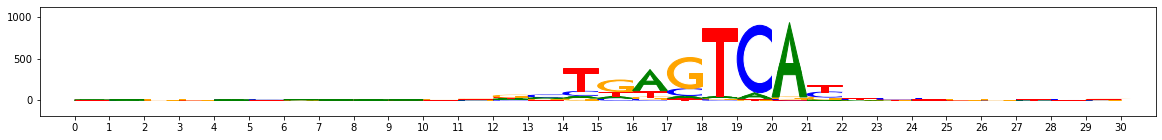

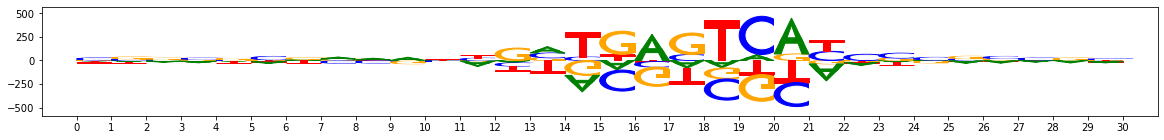

Motif 1 / 5 (445 seqlets)


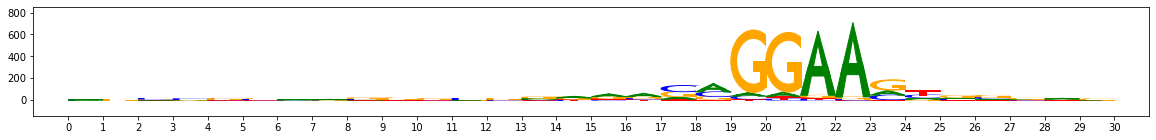

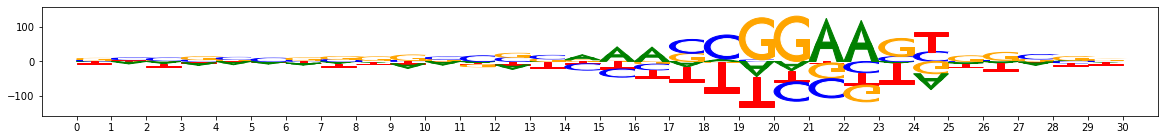

Motif 3 / 5 (171 seqlets)


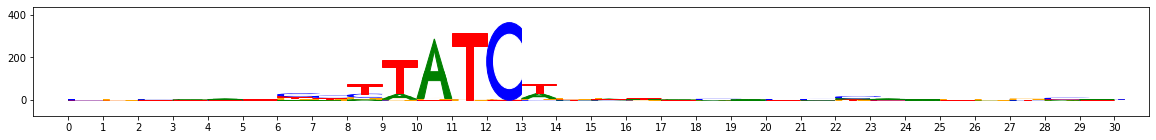

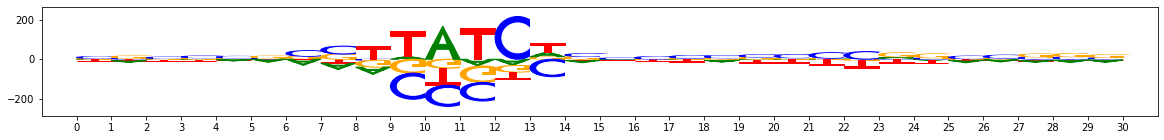

Motif 4 / 5 (85 seqlets)


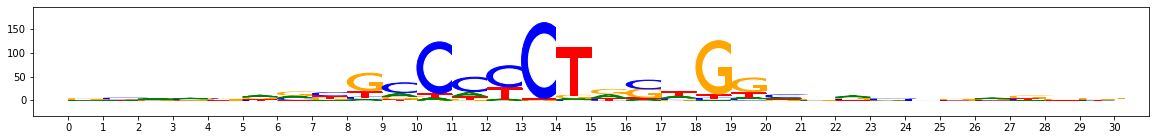

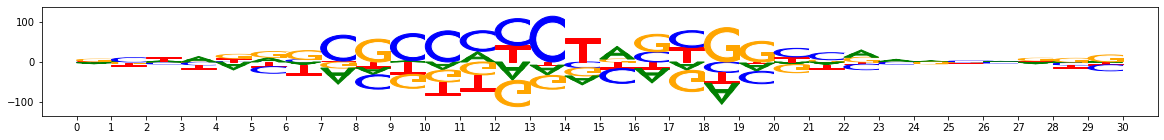

Motif 5 / 5 (72 seqlets)


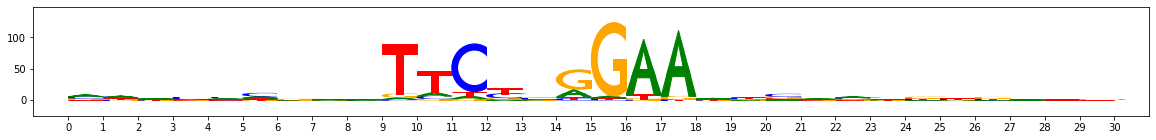

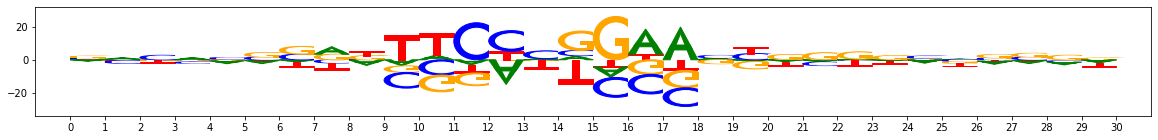

In [22]:
noprior_pfms, noprior_cwms, noprior_num_seqlets = get_pfms_and_cwms(
    noprior_tfm_results, noprior_seqlet_input_seqs, noprior_seqlet_hyp_scores
)